# Energy Consumption and Production Forecasting for Prosumers

## Introduction

In the evolving landscape of the energy sector, prosumers have emerged as transformative contributors to the electricity grid. Prosumers, characterized by their dual role as electricity producers and consumers, harness renewable energy sources, such as solar panels, to generate their own power. Motivated by sustainability and the opportunity to reduce their environmental footprint, prosumers often generate surplus electricity that they can sell back to the grid. This shift from traditional consumer roles not only empowers individuals and entities to become more self-reliant in meeting their energy needs but also fosters a more decentralized and resilient energy infrastructure.

However, this rise in prosumer participation brings forth a set of challenges for the electrical grid. The intermittent and decentralized nature of renewable energy sources, coupled with varying individual consumption patterns, introduces complexities in grid management. As prosumers contribute electricity back to the grid, the challenge lies in efficiently integrating these dynamic and diverse energy inputs. Failure to address these challenges may result in energy imbalances, increased operational costs, and potential instability within the grid.

To navigate these challenges successfully, there is a critical need to accurately predict the behavior of prosumers. Understanding when and how much electricity prosumers will contribute or consume is essential for grid operators to maintain stability and optimize resource allocation. Enhanced predictive models play a pivotal role in anticipating the fluctuating energy patterns associated with prosumer activities. By achieving a more nuanced understanding of prosumer behavior, the energy industry can adapt to this transformative shift, ensuring a resilient and sustainable electrical grid for the future.

## Problem Statement

The goal of this competition is to predict the amount of electricity produced and consumed by Estonian energy customers who have installed solar panels. The prediction must account for various factors such as weather conditions, energy prices, and photovoltaic capacity. The provided datasets include information on prosumer characteristics, electricity prices, gas prices, and weather forecasts.

## Data Overview

### 1. Prosumer Data (train.csv)

- **county:** ID code for the county.
- **is_business:** Boolean indicating whether the prosumer is a business.
- **product_type:** product_type - ID code with the following mapping of codes to contract types: {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}.
- **target:** Consumption or production amount for the hour.
- **is_consumption:** Boolean indicating if the target is consumption or production..
- **datetime:** Estonian time in EET/EEST, representing the start of the 1-hour period.
- **data_block_id:** Identifier for forecast times.
- **prediction_unit_id:** A unique identifier for the county, is_business, and product_type combination. New prediction units can appear or disappear in the test set.

### 2. Gas Prices (gas_prices.csv)

- **origin_date:** Date when day-ahead prices became available.
- **forecast_date:** Date when forecast prices are relevant.
- **lowest/highest_price_per_mwh:** Lowest/highest price of natural gas on the day ahead market.
- **data_block_id:** Identifier for forecast times.

### 3. Client Information (client.csv)

- **product_type**
- **county:** ID code for the county.
- **eic_count:** Aggregated number of consumption points (EICs).
- **installed_capacity:** Installed photovoltaic solar panel capacity.
- **is_business:** Boolean indicating whether the prosumer is a business.
- **date**
- **data_block_id:** Identifier for forecast times.

### 4. Electricity Prices (electricity_prices.csv)

- **origin_date**
- **forecast_date:** Start of the 1-hour period when the price is valid.
- **euros_per_mwh:** Price of electricity on the day ahead markets.
- **data_block_id:** Identifier for forecast times.

### 5. Forecast Weather Data (forecast_weather.csv)

Weather forecasts that would have been available at prediction time. Sourced from the European Centre for Medium-Range Weather Forecasts.

- **[latitude/longitude]:** The coordinates of the weather forecast.
- **origin_datetime:** The timestamp of when the forecast was generated.
- **hours_ahead:** The number of hours between the forecast generation and the forecast weather. Each forecast covers 48 hours in total.
- **temperature:** The air temperature at 2 meters above ground in degrees Celsius. Estimated for the end of the 1-hour period.
- **dewpoint:** The dew point temperature at 2 meters above ground in degrees Celsius. Estimated for the end of the 1-hour period.
- **cloudcover_[low/mid/high/total]:** The percentage of the sky covered by clouds in the following altitude bands: 0-2 km, 2-6, 6+, and total. Estimated for the end of the 1-hour period.
- **10_metre_[u/v]_wind_component:** The [eastward/northward] component of wind speed measured 10 meters above surface in meters per second. Estimated for the end of the 1-hour period.
- **forecast_datetime:** The timestamp of the predicted weather. Generated from origin_datetime plus hours_ahead. This represents the start of the 1-hour period for which weather data are forecasted.
- **direct_solar_radiation:** The direct solar radiation reaching the surface on a plane perpendicular to the direction of the Sun accumulated during the hour, in watt-hours per square meter.
- **surface_solar_radiation_downwards:** The solar radiation, both direct and diffuse, that reaches a horizontal plane at the surface of the Earth, accumulated during the hour, in watt-hours per square meter.
- **snowfall:** Snowfall over the hour in units of meters of water equivalent.
- **total_precipitation:** The accumulated liquid, comprising rain and snow that falls on Earth's surface over the described hour, in units of meters.

### 6. Historical Weather Data (historical_weather.csv)

- **datetime:** This represents the start of the 1-hour period for which weather data are measured.
- **temperature:** Measured at the end of the 1-hour period.
- **dewpoint:** Measured at the end of the 1-hour period.
- **rain:** Different from the forecast conventions. The rain from large scale weather systems of the hour in millimeters.
- **snowfall:** Different from the forecast conventions. Snowfall over the hour in centimeters.
- **surface_pressure:** The air pressure at the surface in hectopascals.
- **cloudcover_[low/mid/high/total]:** Different from the forecast conventions. Cloud cover at 0-3 km, 3-8, 8+, and total.
- **windspeed_10m:** Different from the forecast conventions. The wind speed at 10 meters above ground in meters per second.
- **winddirection_10m:** Different from the forecast conventions. The wind direction at 10 meters above ground in degrees.
- **shortwave_radiation:** Different from the forecast conventions. The global horizontal irradiation in watt-hours per square meter.
- **direct_solar_radiation**
- **diffuse_radiation:** Different from the forecast conventions. The diffuse solar irradiation in watt-hours per square meter.
- **[latitude/longitude]:** The coordinates of the weather station.

## Evaluation

The model evalution criteria will be based on the Mean Absolute Error (MAE) between the predicted return and the observed target.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##  Prosumer Data

In [2]:
train_data = pd.read_csv("./predict-energy-behavior-of-prosumers/train.csv")

In [3]:
train_data.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


In [4]:
# check train data size
train_data.shape

(2018352, 9)

In [5]:
train_data.dtypes

county                  int64
is_business             int64
product_type            int64
target                float64
is_consumption          int64
datetime               object
data_block_id           int64
row_id                  int64
prediction_unit_id      int64
dtype: object

In [6]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
county,2018352.0,7.297034e+00,4.780990,0.0,3.000,7.000,1.100000e+01,15.000
is_business,2018352.0,5.368261e-01,0.498642,0.0,0.000,1.000,1.000000e+00,1.000
product_type,2018352.0,1.898927e+00,1.081766,0.0,1.000,2.000,3.000000e+00,3.000
target,2017824.0,2.748556e+02,909.502378,0.0,0.378,31.133,1.802062e+02,15480.274
is_consumption,2018352.0,5.000000e-01,0.500000,0.0,0.000,0.500,1.000000e+00,1.000
data_block_id,2018352.0,3.218746e+02,182.634314,0.0,166.000,323.000,4.790000e+02,637.000
row_id,2018352.0,1.009176e+06,582648.179597,0.0,504587.750,1009175.500,1.513763e+06,2018351.000
prediction_unit_id,2018352.0,3.304538e+01,19.590594,0.0,16.000,33.000,5.000000e+01,68.000


In [7]:
# check for missing values
train_data.isna().sum()

county                  0
is_business             0
product_type            0
target                528
is_consumption          0
datetime                0
data_block_id           0
row_id                  0
prediction_unit_id      0
dtype: int64

In [8]:
# check for missing datetime
datetimes = pd.to_datetime(train_data["datetime"], format='%Y-%m-%d %H:%M:%S').array.unique()
datetime_fullrange = pd.date_range(start=min(datetimes), end=max(datetimes), freq='1h')
print("Start date/time: ", min(datetimes))
print("End date/time: ", max(datetimes))
print(f"Missing datetimes: {len(datetime_fullrange.difference(datetimes.unique()))}")

Start date/time:  2021-09-01 00:00:00
End date/time:  2023-05-31 23:00:00
Missing datetimes: 0


In [9]:
# Drop missing target samples
train_data.dropna(inplace=True)
train_data.shape

(2017824, 9)

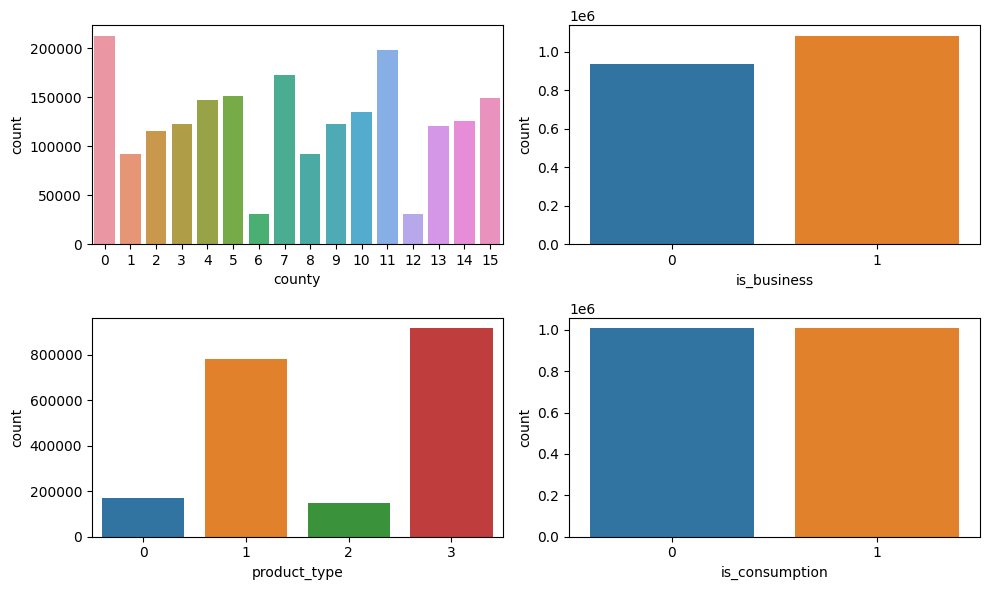

In [10]:
# There are 4 features representing catgories: county, is_business, product_type, is_consumption
# check the count for each category in this features
categorical_features = ["county", "is_business", "product_type", "is_consumption"]

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs = axs.flatten()

for index, col in enumerate(categorical_features):
    _ = sns.countplot(data=train_data, x=col, ax=axs[index])

_ = fig.tight_layout()

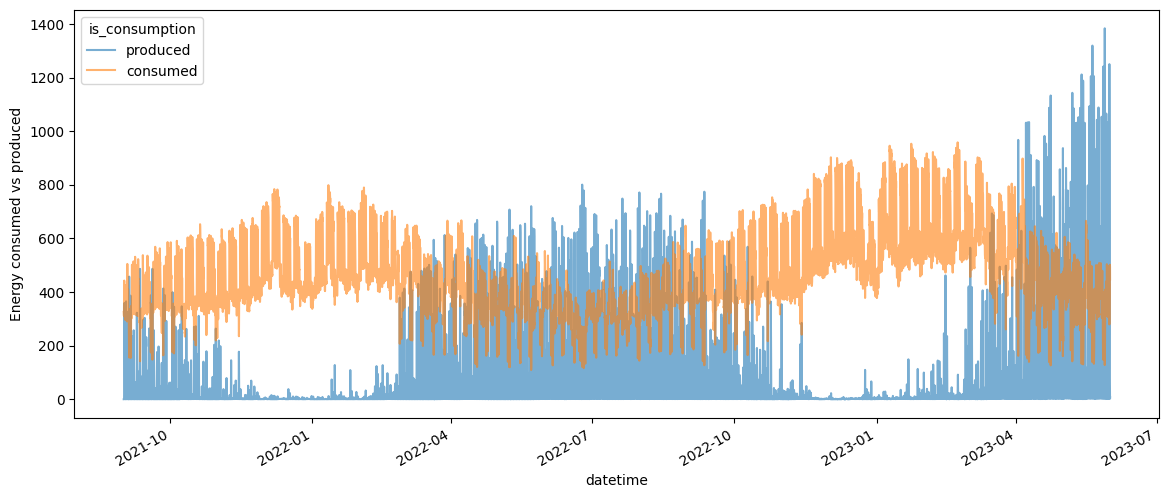

In [11]:
# target column represent the amount of energy consumed vs produced for each segment/hour
# let's see how energy amounts evolve on average
train_data["datetime"] = pd.to_datetime(train_data["datetime"], format='%Y-%m-%d %H:%M:%S')
avg_target = train_data.groupby(['datetime','is_consumption'])['target'].mean() \
                       .unstack().rename({0: 'produced', 1:'consumed'}, axis=1)

avg_target.plot(figsize=(14, 6), alpha=0.6)
_ = plt.ylabel('Energy consumed vs produced')

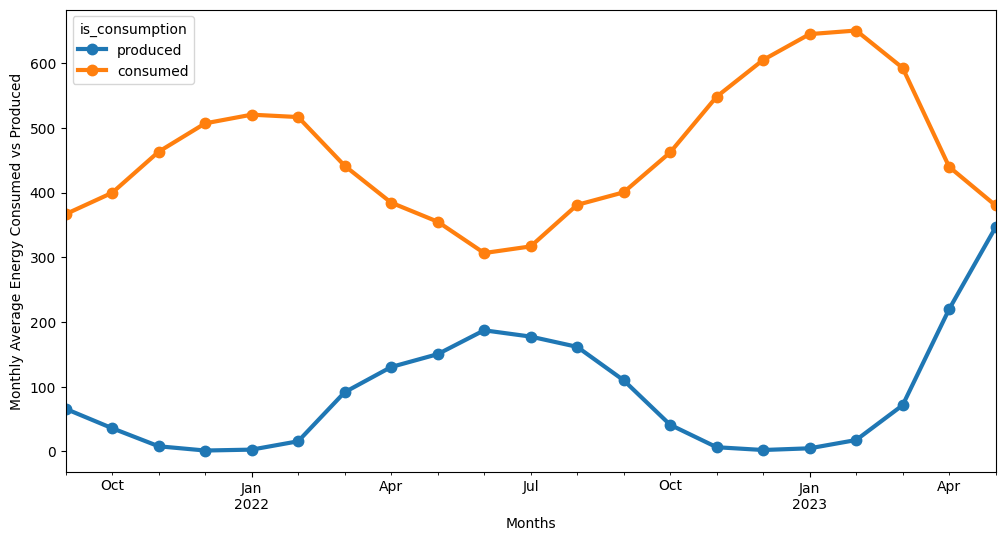

In [12]:
# plot of monthly average energy
avg_target.resample('M').mean().plot(figsize=(12,6), linewidth=3, marker=".", markersize=15)
plt.xlabel("Months")
_ = plt.ylabel('Monthly Average Energy Consumed vs Produced')

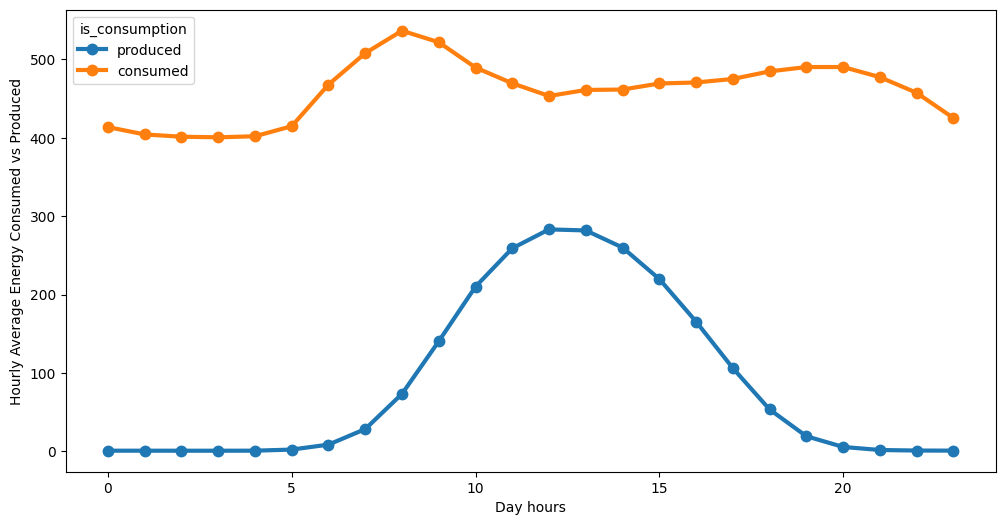

In [13]:
avg_target.groupby(avg_target.index.hour).mean().plot(figsize=(12, 6), linewidth=3, marker=".", markersize=15)
plt.xlabel("Day hours")
_ = plt.ylabel("Hourly Average Energy Consumed vs Produced")

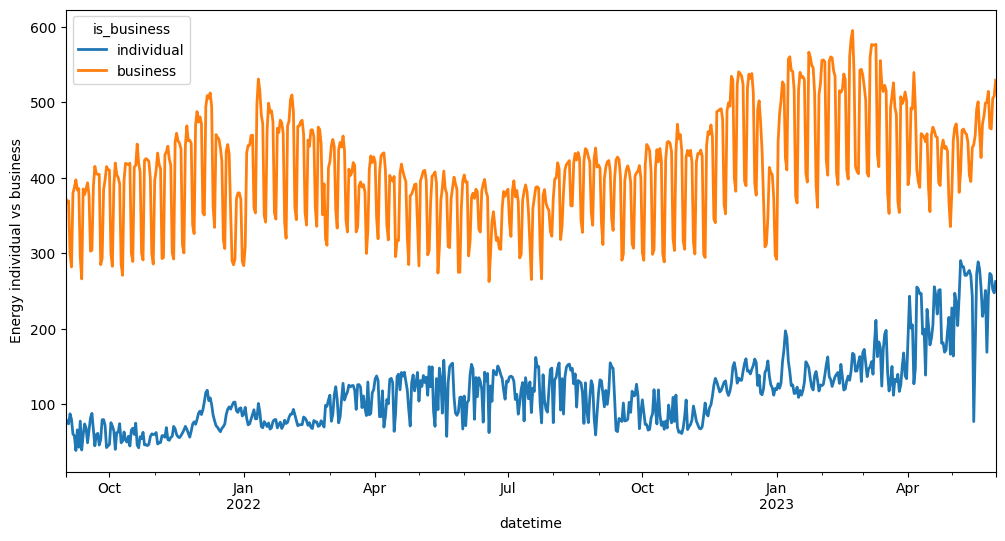

In [14]:
avg_target_business = train_data.groupby(['datetime','is_business'])['target'].mean() \
                       .unstack().rename({0: 'individual', 1:'business'}, axis=1)

avg_target_business.resample('D').mean().plot(figsize=(12,6), linewidth=2)
_ = plt.ylabel('Energy individual vs business')

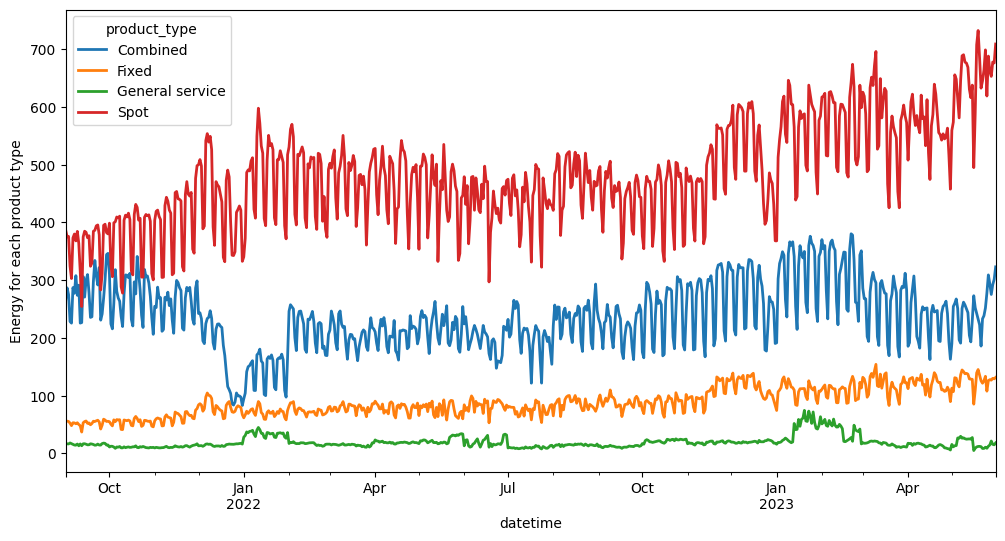

In [15]:
avg_target_product = train_data.groupby(['datetime','product_type'])['target'].mean() \
                       .unstack().rename({0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}, axis=1)

avg_target_product.resample('D').mean().plot(figsize=(12,6), linewidth=2)
_ = plt.ylabel('Energy for each product type')

In [16]:
# Extract date/time features from datetime column
train_data['hour'] = train_data.datetime.dt.hour
train_data['dayofweek'] = train_data.datetime.dt.dayofweek
train_data['week'] = train_data.datetime.dt.isocalendar().week.astype("int")
train_data['dayofyear'] = train_data.datetime.dt.dayofyear
train_data['month'] = train_data.datetime.dt.month
train_data['year'] = train_data.datetime.dt.year

In [17]:
train_data.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,hour,dayofweek,week,dayofyear,month,year
0,0,0,1,0.713,0,2021-09-01,0,0,0,0,2,35,244,9,2021
1,0,0,1,96.590,1,2021-09-01,0,1,0,0,2,35,244,9,2021
2,0,0,2,0.000,0,2021-09-01,0,2,1,0,2,35,244,9,2021
3,0,0,2,17.314,1,2021-09-01,0,3,1,0,2,35,244,9,2021
4,0,0,3,2.904,0,2021-09-01,0,4,2,0,2,35,244,9,2021


##  Electricity Prices Data

In [18]:
# explore electricity prices data
prices_data = pd.read_csv("./predict-energy-behavior-of-prosumers/electricity_prices.csv")

In [19]:
prices_data.head()

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


In [20]:
prices_data.shape

(15286, 4)

In [21]:
prices_data.dtypes

forecast_date     object
euros_per_mwh    float64
origin_date       object
data_block_id      int64
dtype: object

In [22]:
prices_data.isna().sum()

forecast_date    0
euros_per_mwh    0
origin_date      0
data_block_id    0
dtype: int64

In [23]:
# check for missing datetime
datetimes = pd.to_datetime(prices_data["forecast_date"], format='%Y-%m-%d %H:%M:%S').array.unique()
datetime_fullrange = pd.date_range(start=min(datetimes), end=max(datetimes), freq='1h')
print("Start date/time: ", min(datetimes))
print("End date/time: ", max(datetimes))

missing_dates = datetime_fullrange.difference(datetimes.unique())
print(f"Missing datetimes ({len(missing_dates)}): {missing_dates}")

Start date/time:  2021-09-01 00:00:00
End date/time:  2023-05-30 23:00:00
Missing datetimes (2): DatetimeIndex(['2022-03-27 02:00:00', '2023-03-26 02:00:00'], dtype='datetime64[ns]', freq=None)


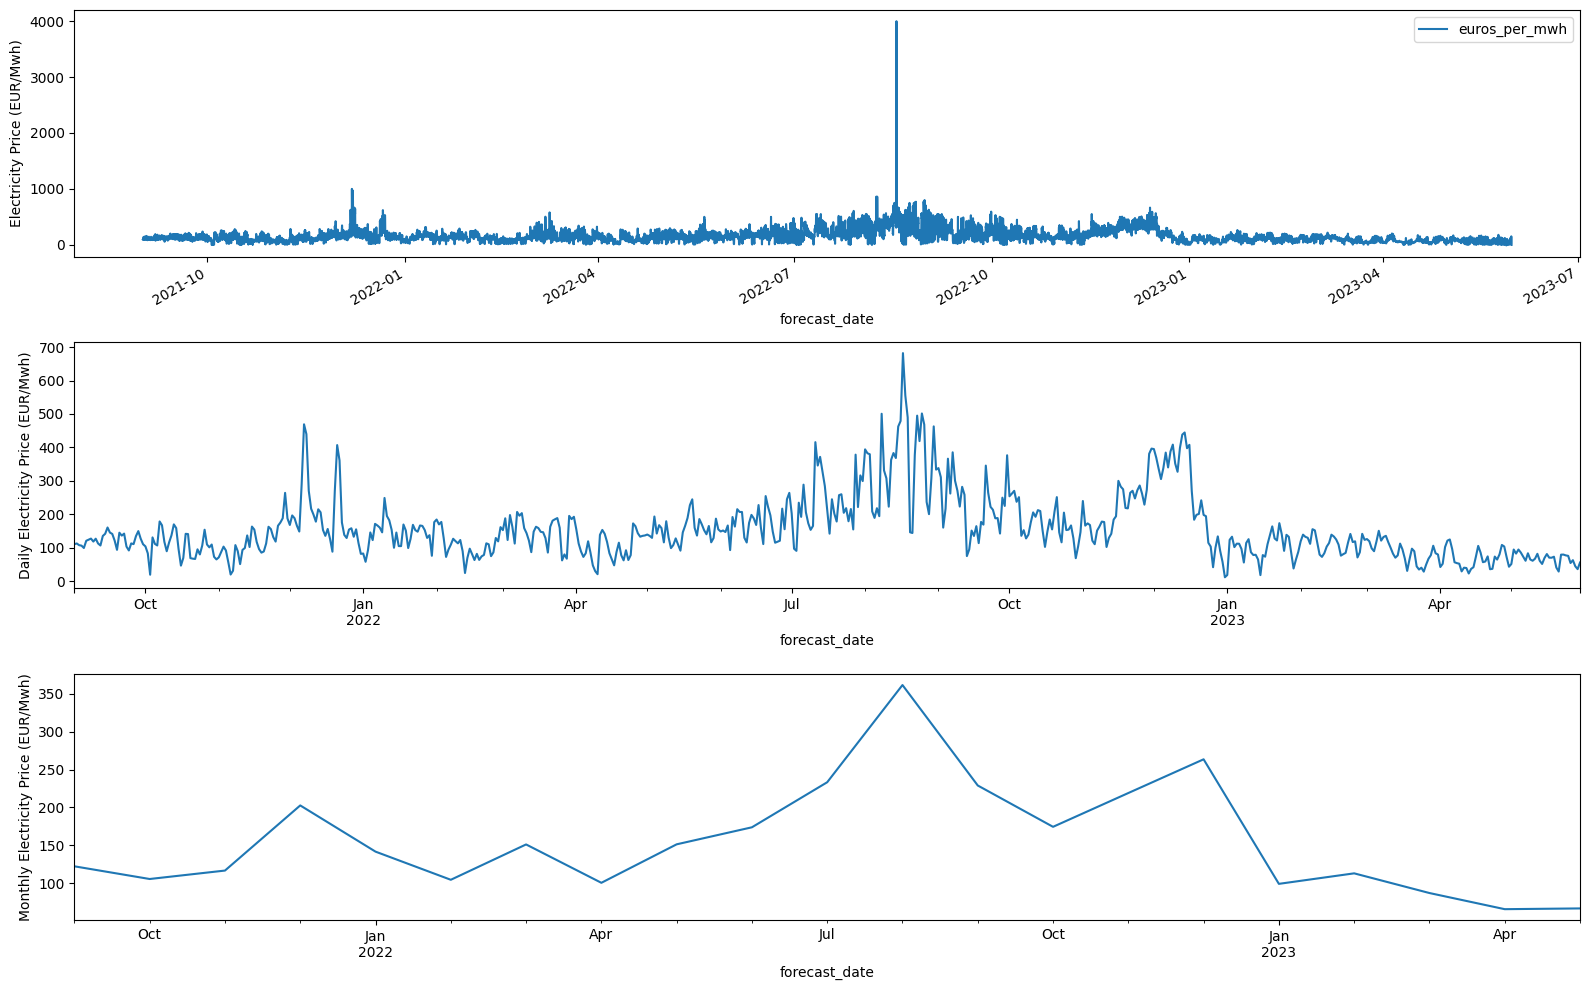

In [24]:
prices_data["forecast_date"] = pd.to_datetime(prices_data["forecast_date"], format='%Y-%m-%d %H:%M:%S')

fig, axs= plt.subplots(3, 1, figsize=(16, 10))
prices_data.plot(y="euros_per_mwh", x="forecast_date", ax=axs[0])
axs[0].set_ylabel("Electricity Price (EUR/Mwh)")
# average price per day
prices_data.resample('D', on="forecast_date").mean(numeric_only=True)["euros_per_mwh"].plot(ax=axs[1])
axs[1].set_ylabel("Daily Electricity Price (EUR/Mwh)")
# average price per month
prices_data.resample('M', on="forecast_date").mean(numeric_only=True)["euros_per_mwh"].plot(ax=axs[2])
axs[2].set_ylabel("Monthly Electricity Price (EUR/Mwh)")

_ = plt.tight_layout()

##  Client Information Data

In [25]:
client_data = pd.read_csv("./predict-energy-behavior-of-prosumers/client.csv")

In [26]:
client_data.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


In [27]:
client_data.shape

(41919, 7)

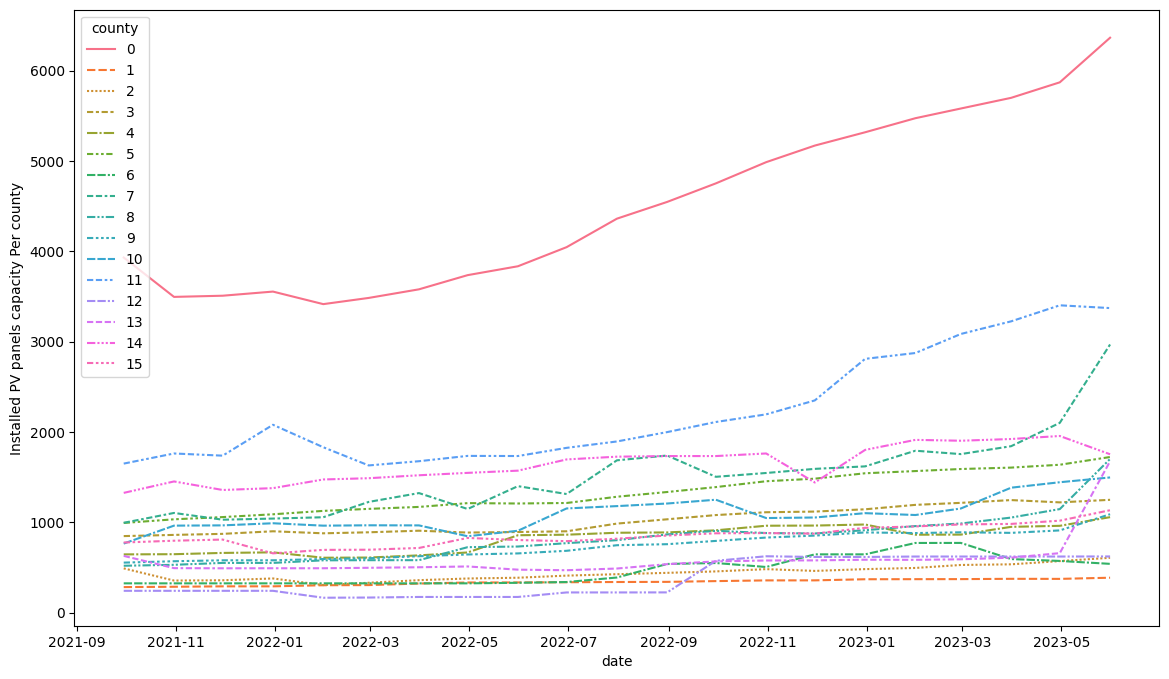

In [28]:
client_data["date"] = pd.to_datetime(client_data["date"], format='%Y-%m-%d')

plt.figure(figsize=(14, 8))
sns.lineplot(client_data.groupby(["date", "county"]).mean(numeric_only=True).unstack()["installed_capacity"].resample("M").mean())
_ = plt.ylabel("Installed PV panels capacity Per county")